# Banzhaf Values for data valuation

This notebook shows how to compute Banzhaf values using pyDVL.

In order to illustrate the practical advantages, we will predict the popularity of songs in the dataset [Top Hits Spotify from 2000-2019](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019), and highlight how data valuation can help investigate and boost the performance of the models. In doing so, we will describe the basic usage patterns of pyDVL.

Recall that data value is a function of three things:

1. The dataset.
2. The model.
3. The performance metric or scoring function.

Below we will describe how to instantiate each one of these objects and how to use them for data valuation. Please also see the [documentation on data valuation](../../value/).

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
random.seed(random_state)

We will be using the following functions from pyDVL. The main entry point is the function `compute_banzhaf_semivalues()`.
In order to use it we need the classes [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset), [Utility](../../api/pydvl/utils/utility/#pydvl.utils.utility.Utility) and [Scorer](../../api/pydvl/utils/score/#pydvl.utils.score.Scorer).

In [3]:
%autoreload
from pydvl.reporting.plots import plot_shapley
from pydvl.utils.dataset import GroupedDataset
from support.shapley import load_spotify_dataset
from pydvl.value import *

## Loading and grouping the dataset

pyDVL provides a support function for this notebook, `load_spotify_dataset()`, which downloads data on songs published after 2014, and splits 30% of data for testing, and 30% of the remaining data for validation. The return value is a triple of training, validation and test data as lists of the form `[X_input, Y_label]`.

In [4]:
training_data, val_data, test_data = load_spotify_dataset(
    val_size=0.3, test_size=0.3, target_column="popularity", random_state=random_state
)

In [5]:
# In CI we only use a subset of the training set
if is_CI:
    ci_test_artists = ["Billie Eilish", "DJ Snake", "Eminem", "Adele", "Maroon 5"]
    training_data[0] = training_data[0][
        training_data[0]["artist"].isin(ci_test_artists)
    ]
    training_data[1] = training_data[1][training_data[0].index]

In [6]:
training_data[0].head()

,artist,song,duration_ms,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
1561,Fetty Wap,679 (feat. Remy Boyz),196693,True,2015,0.618,0.717,7,-5.738,1,0.3180,0.00256,0.000000,0.6250,0.603,190.050,8
1410,Meghan Trainor,All About That Bass,187920,True,2015,0.807,0.887,9,-3.726,1,0.0503,0.05730,0.000003,0.1240,0.961,134.052,14
1772,Katy Perry,Chained To The Rhythm,237733,False,2017,0.562,0.800,0,-5.404,1,0.1120,0.08140,0.000000,0.1990,0.471,95.029,14
1670,Sigala,Sweet Lovin' - Radio Edit,202149,False,2015,0.683,0.910,10,-1.231,1,0.0515,0.05530,0.000005,0.3360,0.674,124.977,15
1780,Liam Payne,Strip That Down,204502,False,2017,0.869,0.485,6,-5.595,1,0.0545,0.24600,0.000000,0.0765,0.527,106.028,14


The dataset has many high-level features, some quite intuitive ('duration_ms' or 'tempo'), while others are a bit more cryptic ('valence'?). For information on each feature, please consult [the dataset's website](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019).

In our analysis, we will use all the columns, except for 'artist' and 'song', to predict the 'popularity' of each song. We will nonetheless keep the information on song and artist in a separate object for future reference.

In [7]:
song_name = training_data[0]["song"]
artist = training_data[0]["artist"]
training_data[0] = training_data[0].drop(["song", "artist"], axis=1)
test_data[0] = test_data[0].drop(["song", "artist"], axis=1)
val_data[0] = val_data[0].drop(["song", "artist"], axis=1)

Input and label data are then used to instantiate a [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset) object:

In [8]:
dataset = Dataset(*training_data, *val_data)

The calculation of exact Banzhaf semivalues is computationally very expensive (exponentially so!) because it requires training the model on every possible subset of the training set. For this reason, PyDVL implements techniques to speed up the calculation, such as [Monte Carlo approximations](../../api/pydvl/value/shapley/montecarlo/), [surrogate models](../../api/pydvl/utils/utility/#pydvl.utils.utility.DataUtilityLearning) or [caching](../../api/pydvl/utils/caching/) of intermediate results and grouping of data to calculate group Shapley values instead of single data points.

In our case, we will group songs by artist and calculate the Shapley value for the artists. Given the [pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) for 'artist', to group the dataset by it, one does the following:

In [9]:
grouped_dataset = GroupedDataset.from_dataset(dataset=dataset, data_groups=artist)

## Creating the utility and computing Banzhaf semivalues

Now we can calculate the contribution of each group to the model performance.

As a model, we use scikit-learn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), but pyDVL can work with any model from sklearn, xgboost or lightgbm. More precisely, any model that implements the protocol [pydvl.utils.types.SupervisedModel](../../api/pydvl/utils/types/#pydvl.utils.types.SupervisedModel), which is just the standard sklearn interface of `fit()`,`predict()` and `score()` can be used to construct the utility.

The third and final component is the scoring function. It can be anything like accuracy or $R^2$, and is set with a string from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html). Please refer to that documentation on information on how to define your own scoring function.

We group dataset, model and scoring function into an instance of [Utility](../../api/pydvl/utils/utility/#pydvl.utils.utility.Utility).

In [10]:
# Compute regular Banzhaf semivalue
utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_dataset,
    scorer=Scorer("neg_mean_absolute_error", default=0.0),
)
values = compute_banzhaf_semivalues(
    utility,
    # Stop if the standard error is below 1% of the range of the values (which is ~2),
    # or if the number of updates exceeds 1000
    done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
    n_jobs=-1,
)
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
/Users/jakobkruse/Documents/Projects/pyDVL/src/pydvl/parallel/backends/joblib.py:47: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(


Let's take a look at the returned dataframe:

In [11]:
df.head()

,data_value,data_value_stderr
5 Seconds of Summer,-0.581937,0.101380
Shawn Mendes,-0.552785,0.166859
Alessia Cara,-0.545159,0.054849
Liam Payne,-0.405800,0.262284
Kendrick Lamar,-0.405719,0.240342


Let us plot the results. In the next cell we will take the 30 artists with the lowest score and plot their values with 95% Normal confidence intervals. Keep in mind that Monte Carlo Banzhaf is typically very noisy, and it can take many steps to arrive at a clean estimate.

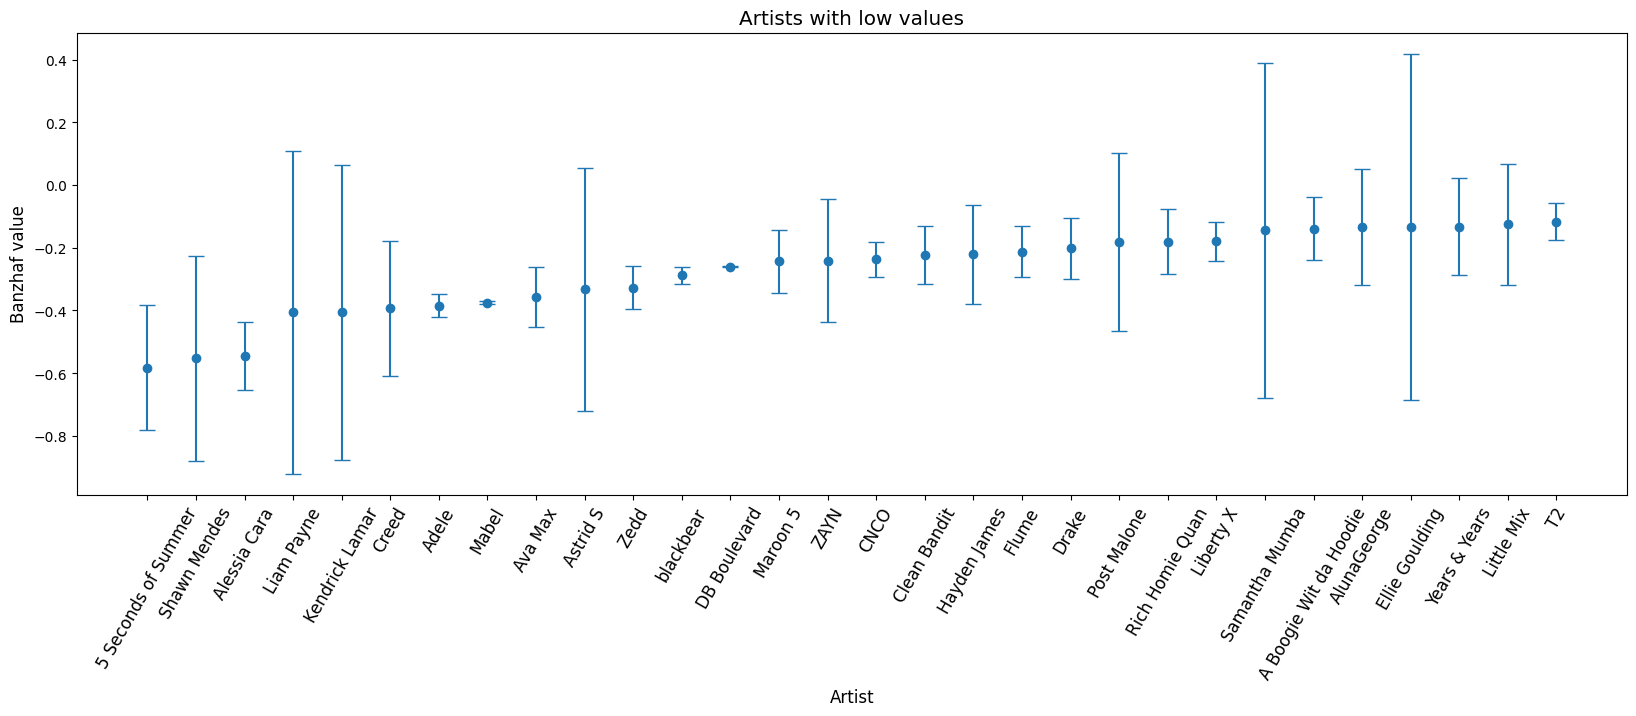

In [12]:
low_dvl = df.iloc[:30]
plot_shapley(
    low_dvl,
    level=0.05,
    title="Artists with low values",
    xlabel="Artist",
    ylabel="Banzhaf value",
)
plt.show()

We can immediately see that many artists (groups of samples) have very low, even negative value, which means that they tend to decrease the total score of the model when present in the training set! What happens if we remove them?

In the next cell we create a new training set excluding the artists with the lowest scores:

In [13]:
low_dvl_artists = df.iloc[: int(0.2 * len(df))].index.to_list()
artist_filter = ~artist.isin(low_dvl_artists)
X_train_good_dvl = training_data[0][artist_filter]
y_train_good_dvl = training_data[1][artist_filter]

Now we will use this "cleaned" dataset to retrain the same model and compare its mean absolute error to the one trained on the full dataset. Notice that the score now is calculated using the test set, while in the calculation of the Shapley values we were using the validation set.

In [14]:
model_good_data = GradientBoostingRegressor(n_estimators=3).fit(
    X_train_good_dvl, y_train_good_dvl
)
error_good_data = mean_absolute_error(
    model_good_data.predict(test_data[0]), test_data[1]
)

model_all_data = GradientBoostingRegressor(n_estimators=3).fit(
    training_data[0], training_data[1]
)
error_all_data = mean_absolute_error(model_all_data.predict(test_data[0]), test_data[1])

print(f"Improvement: {100*(error_all_data - error_good_data)/error_all_data:02f}%")

Improvement: 13.635495%


The score has improved by almost 14%! This is quite an important result, as it shows a consistent process to improve the performance of a model by excluding data points from its training set.

<div class="alert alert-warning">

One must however proceed with caution instead of simply throwing away data. For one, `mean_absolute_error` is an estimate of generalization error on unseen data, so the improvement we see on the test set might not be as large upon deployment. It would be advisable to cross-validate this whole process to obtain more conservative estimates. It is also advisable to manually inspect the artists with low value and to try to understand the reason why the model behaves like it does. Finally, remember that **the value depends on the model chosen**! Artists that are detrimental to the Gradient Boosting Regressor might be informative for a different model (although it is likely that the worst ones share some characteristic making them "bad" for other regressors).

</div>

## Evaluation on anomalous data

One interesting test is to corrupt some data and to monitor how their value changes. To do this, we will take one of the artists with the highest value and set the popularity of all their songs to 0.

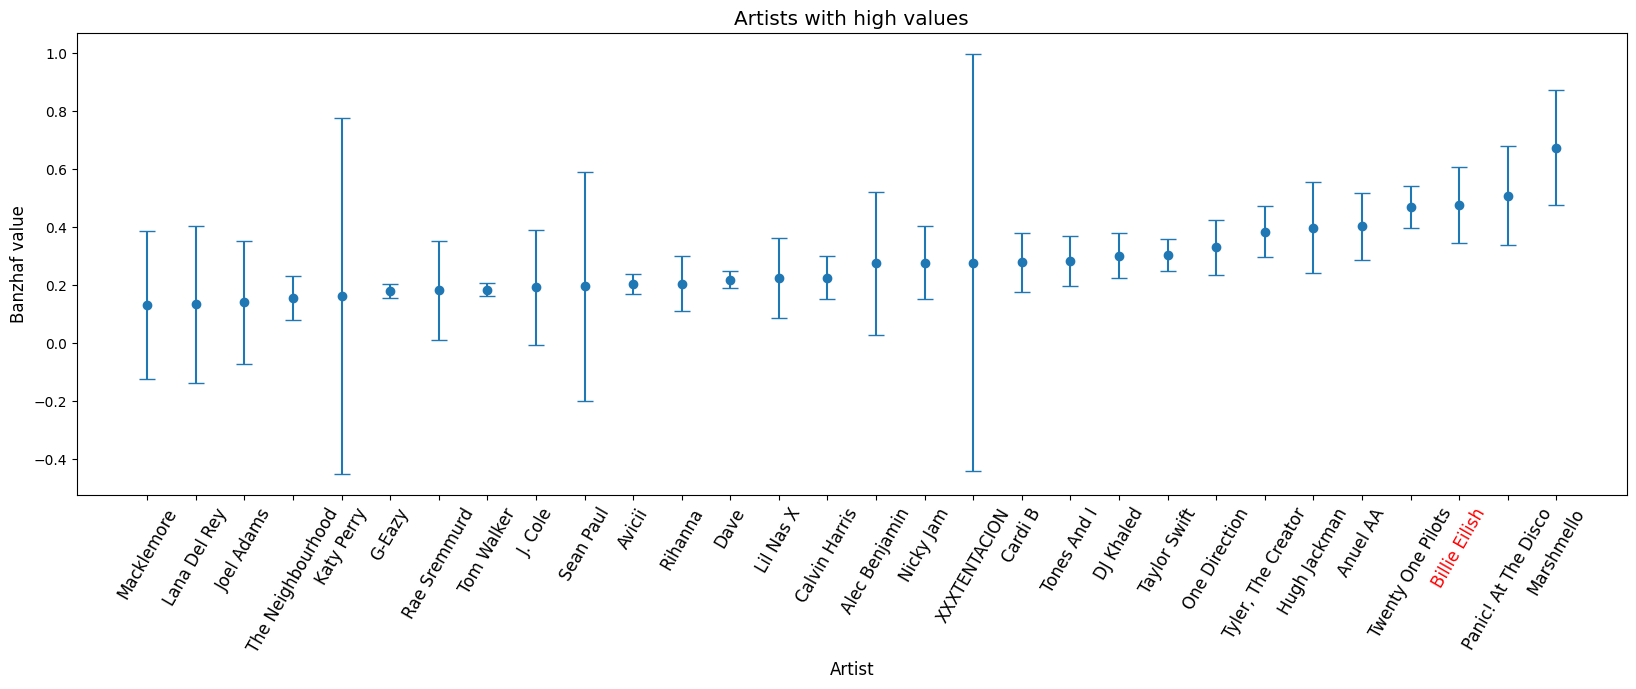

In [15]:
high_dvl = df.iloc[-30:]
ax = plot_shapley(
    high_dvl,
    title="Artists with high values",
    xlabel="Artist",
    ylabel="Banzhaf value",
)
ax.get_xticklabels()[high_dvl.index.get_loc("Billie Eilish")].set_color("red")
plt.show()

Let us take all the songs by Billie Eilish, set their score to 0 and re-calculate the Banzhaf values.

In [16]:
y_train_anomalous = training_data[1].copy(deep=True)
y_train_anomalous[artist == "Billie Eilish"] = 0
anomalous_dataset = Dataset(
    x_train=training_data[0],
    y_train=y_train_anomalous,
    x_test=val_data[0],
    y_test=val_data[1],
)
grouped_anomalous_dataset = GroupedDataset.from_dataset(anomalous_dataset, artist)
anomalous_utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_anomalous_dataset,
    scorer=Scorer("neg_mean_absolute_error", default=0.0),
)
values = compute_banzhaf_semivalues(
    anomalous_utility,
    done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
    n_jobs=-1,
)
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
/Users/jakobkruse/Documents/Projects/pyDVL/src/pydvl/parallel/backends/joblib.py:47: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(


Let us now consider the low-value artists (at least for predictive purposes, no claims are made about their artistic value!) and plot the results

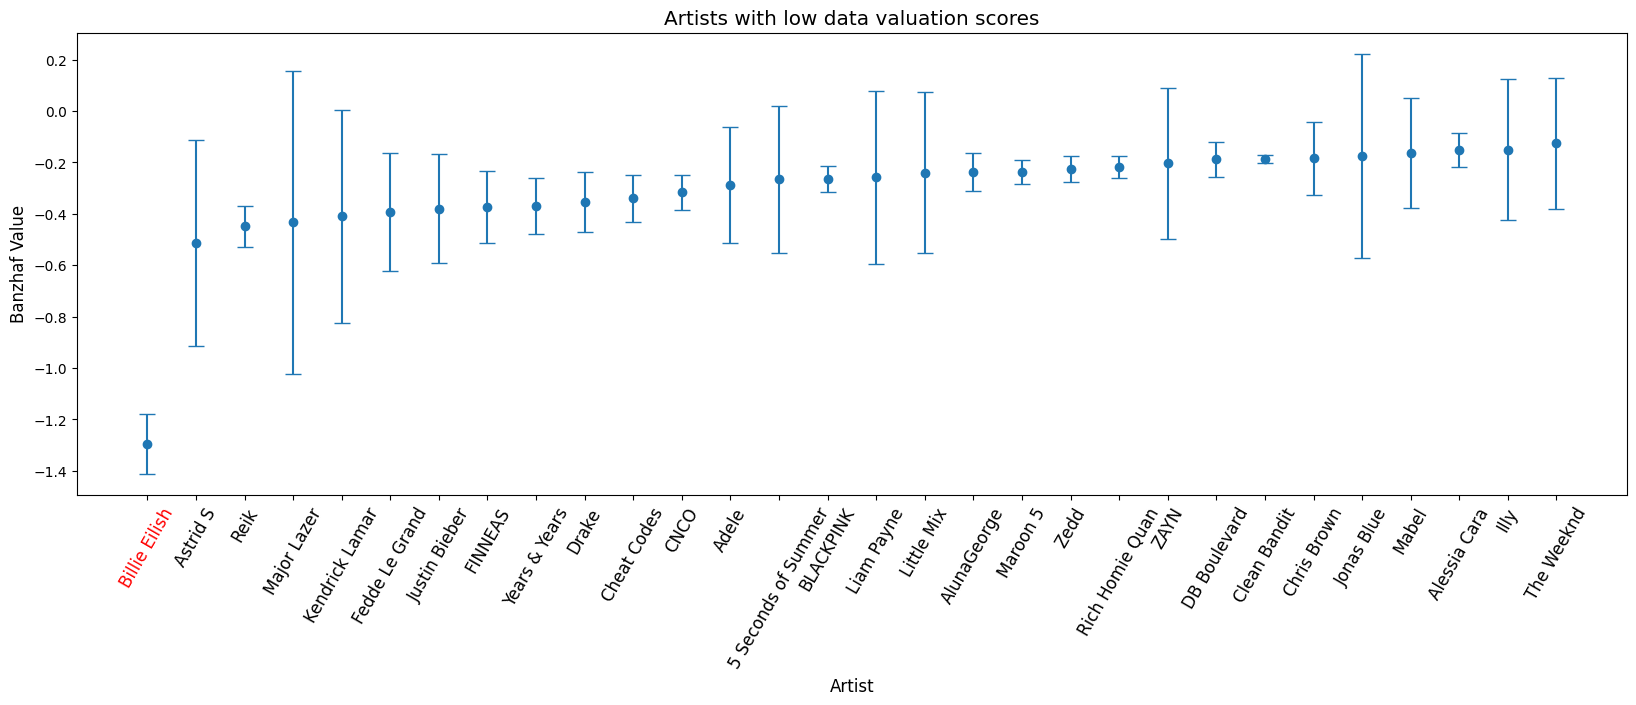

In [17]:
low_dvl = df.iloc[:30]
ax = plot_shapley(
    low_dvl,
    title="Artists with low data valuation scores",
    xlabel="Artist",
    ylabel="Banzhaf Value",
)
ax.get_xticklabels()[low_dvl.index.get_loc("Billie Eilish")].set_color("red")
plt.show()

And Billie Eilish (our anomalous data group) has moved from top contributor to having negative impact on the performance of the model, as expected!

What is going on? A popularity of 0 for Billie Eilish's songs is inconsistent with listening patterns for other artists. In artificially setting this, we degrade the predictive power of the model.

By dropping low-value groups or samples, one can often increase model performance, but by *inspecting* them, it is possible to identify bogus data sources or acquisition methods.


### Maximum Sample Reuse Banzhaf

Now, we want to use a method called Maximum Sample Reuse (MSR) which reuses samples for updating the Banzhaf values. The method is introduced by Wang et al. in the paper *Data Banzhaf: A Robust Data Valuation Framework for Machine Learning*.

In [18]:
# Compute MSR Banzhaf semivalue
utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_dataset,
    scorer=Scorer("neg_mean_absolute_error", default=0.0),
)
values = compute_msr_banzhaf_semivalues(
    utility,
    done=RankStability(0.0005),
    n_jobs=-1,
    progress=True,
)
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

  0%|          | 0/100 [00:00<?, ?%/s]/Users/jakobkruse/Documents/Projects/pyDVL/src/pydvl/parallel/backends/joblib.py:47: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
  0%|          | 0.0/100 [00:02<?, ?%/s]/Users/jakobkruse/Documents/Projects/pyDVL/venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|█████████▉| 99.58575977052564/100 [00:02<00:00, 34.64%/s]


In [19]:
df.head()

,data_value,data_value_stderr
Liberty X,-1.143853,0.382673
BLACKPINK,-1.067160,0.442940
Liam Payne,-0.775598,0.530834
Reik,-0.775269,0.359365
Alessia Cara,-0.756135,0.402948


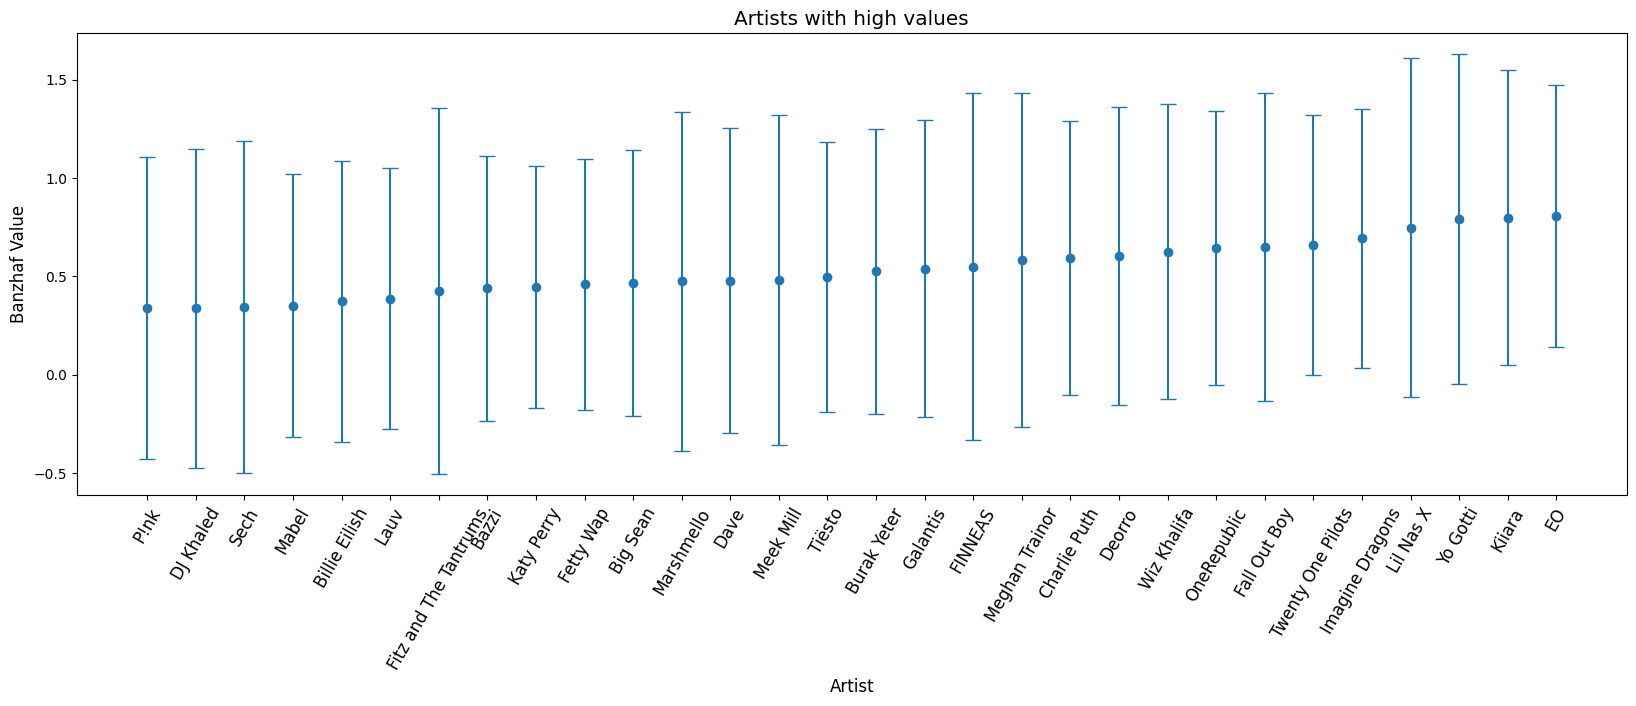

In [20]:
high_dvl = df.iloc[-30:]
ax = plot_shapley(
    high_dvl,
    title="Artists with high values",
    xlabel="Artist",
    ylabel="Banzhaf Value",
)
plt.show()

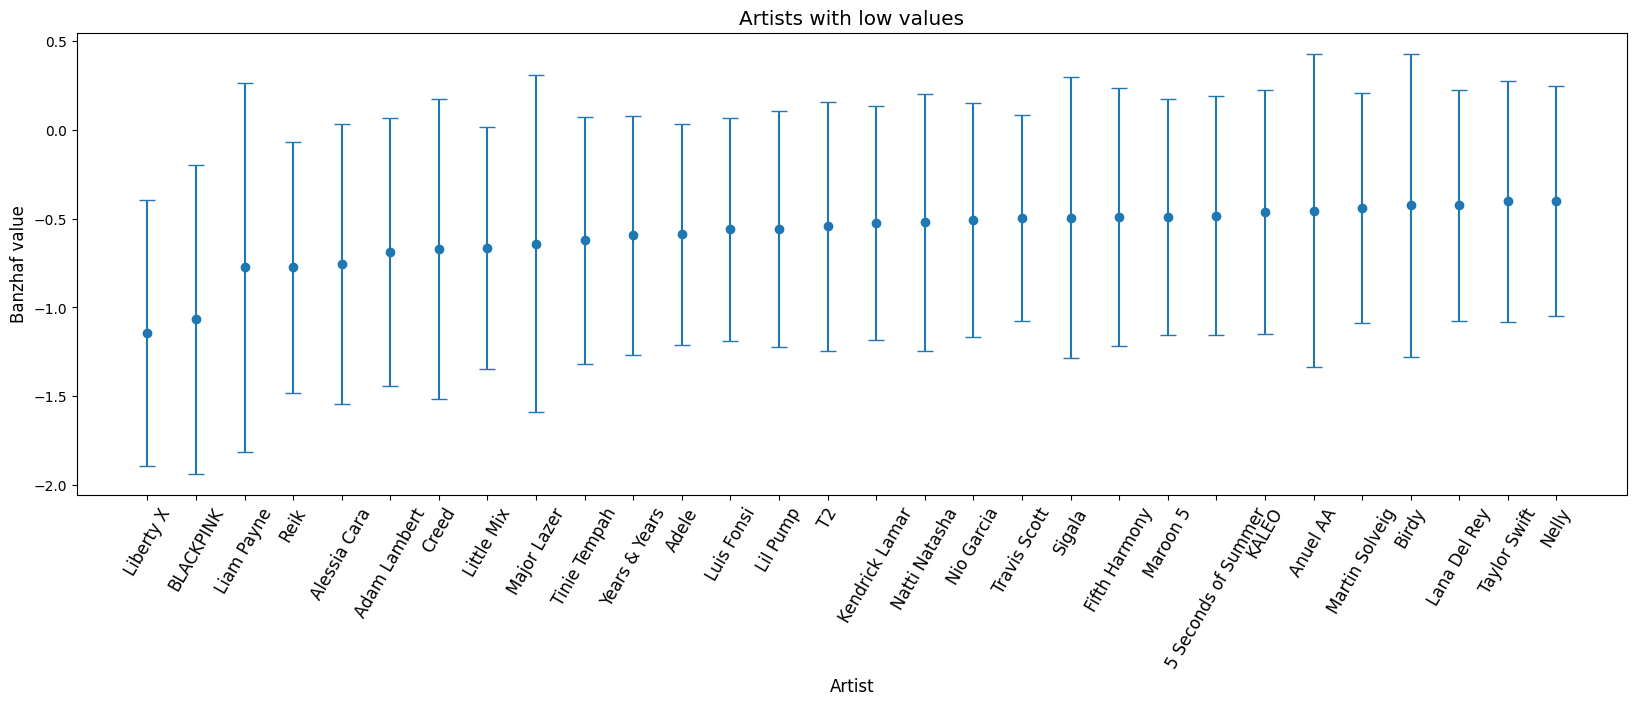

In [21]:
low_dvl = df.iloc[:30]
ax = plot_shapley(
    low_dvl,
    title="Artists with low values",
    xlabel="Artist",
    ylabel="Banzhaf value",
)
plt.show()

### Compare convergence speed of Banzhaf and MSR Banzhaf Values

While the conventional Banzhaf values algorithm evaluates the utility twice to do one update of the Banzhaf values, the Maximum Samples Reuse (MSR) algorithm promises higher sample efficiency because it updates multiple samples per one evaluation of the utility. This part of the notebook takes a look at the convergence speed of the algorithms compared with each other.

In [22]:
# Regular Banzhaf semivalues
num_iterations = 1000
utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_dataset,
    scorer=Scorer("neg_mean_absolute_error", default=0.0),
)
history_normal = HistoryDeviation(n_steps=num_iterations, rtol=1e-9)
mc_values = compute_banzhaf_semivalues(
    utility,
    done=MaxChecks(num_iterations + 2) | history_normal,
    n_jobs=-1,
    progress=True,
)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/Users/jakobkruse/Documents/Projects/pyDVL/src/pydvl/parallel/backends/joblib.py:47: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
100%|█████████▉| 99.7005988023952/100 [00:04<00:00, 20.92%/s]   


In [23]:
# MSR Banzhaf values
history_msr = HistoryDeviation(n_steps=num_iterations, rtol=1e-9)
msr_values = compute_msr_banzhaf_semivalues(
    utility, done=MaxChecks(num_iterations + 2) | history_msr, n_jobs=-1, progress=True
)

100%|█████████▉| 99.50099800399201/100 [00:04<00:00, 23.96%/s]  /Users/jakobkruse/Documents/Projects/pyDVL/venv/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|█████████▉| 99.50099800399201/100 [00:04<00:00, 22.14%/s]


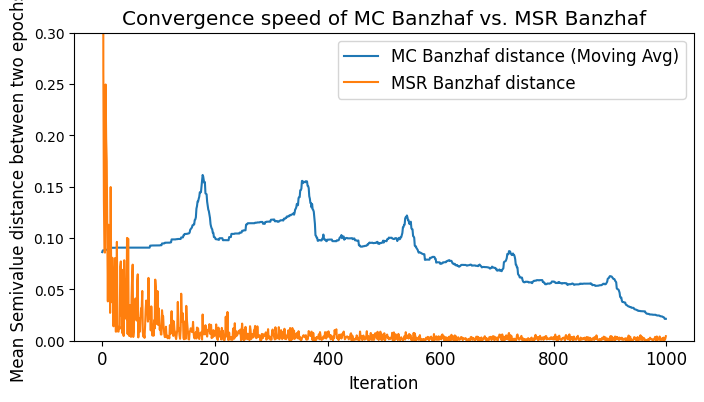

In [24]:
# Compare convergence speed of both methods
import numpy as np

bz_values = history_normal._memory
msr_values = history_msr._memory
bz_distances = []
msr_distances = []
for iteration in range(num_iterations):
    bz_abs_dist = np.abs(bz_values[:, iteration] - bz_values[:, iteration + 1])
    if bz_abs_dist.max() == 0.0:
        bz_distances.append(0.0)
    else:
        bz_distances.append(np.mean(bz_abs_dist[bz_abs_dist > 0]))
    msr_abs_dist = np.abs(msr_values[:, iteration] - msr_values[:, iteration + 1])
    if msr_abs_dist.max() == 0.0:
        msr_distances.append(0.0)
    else:
        msr_distances.append(np.mean(msr_abs_dist[msr_abs_dist > 0]))

bz_moving_avg = np.convolve(bz_distances, np.ones(200) / 200, mode="same")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(
    list(range(num_iterations)), bz_moving_avg, label="MC Banzhaf distance (Moving Avg)"
)
ax.plot(list(range(num_iterations)), msr_distances, label="MSR Banzhaf distance")
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean Semivalue distance between two epochs")
ax.set_title("Convergence speed of MC Banzhaf vs. MSR Banzhaf")
ax.set_ylim([0, 0.3])
plt.legend()
plt.show()

The plot above visualizes the convergence speed of regular Banzhaf vs Maximum Sample Reuse Banzhaf. It shows the average magnitude of how much the semivalues are updated in every step of the algorithm. As you can see, MSR Banzhaf converges much faster. After 1000 iterations (subsets tried), Monte Carlo Banzhaf has evaluated the marginal function about 5 times per data point. For maximum sample reuse, the semivalue of each data point was updated on average 500 times. Due to this, the values converge much quicker.

In [25]:
mc_values = compute_banzhaf_semivalues(
    u=utility, sampler_t=UniformSampler, done=MaxChecks(10000), n_jobs=-1, progress=True
)
msr_values = compute_msr_banzhaf_semivalues(
    u=utility, done=MaxChecks(10000), n_jobs=-1, progress=True
)

100%|█████████▉| 99.98/100 [00:18<00:00,  5.48%/s]                
100%|█████████▉| 99.97/100 [00:17<00:00,  5.60%/s]              


In [26]:
from scipy.stats import spearmanr

print(np.linalg.norm(mc_values.values - msr_values.values))
print(spearmanr(mc_values.values, msr_values.values))

0.4268817759913272
SignificanceResult(statistic=0.9189952335500745, pvalue=1.1286299472107335e-74)
